In [1]:
import numpy
import pandas
import timeit

In [2]:
samples = ['BLCA', 'BRCA', 'CESC', 'CHOL', 'COAD',
           'ESCA', 'GBM', 'HNSC', 'KICH', 'KIRC',
           'KIRP', 'LIHC', 'LUAD', 'LUSC', 'PAAD', 
           'PCPG', 'PRAD', 'READ', 'SARC', 'STAD', 
           'THCA', 'THYM', 'UCEC']

In [3]:
len(samples)

23

In [5]:
def assign_prevailing_forms(dataset: pandas.DataFrame) -> pandas.DataFrame:
    ''' 
    Given initial TCGA dataset, iterate through unique genes and:
    1. If gene has a single isoform in dataset, simply assign it to all samples
    2. If gene has multiple isoforms, find isoforms with maximum abundance for
    each sample using .idxmax() method and assign the result to samples, 
    collapsing data to one row per gene.
    '''
    #Construct a dataframe to return from initial dataset, drop unnecessary columns
    result = (dataset.copy()
              .drop(['UniProt', 'canonical', 'chr', 'ucsc', 'Avg'], axis=1)
              .drop_duplicates('Gene')
              .astype(str)
              .set_index('Gene')
              .drop(['-'], axis=0)) #Some isoforms have Gene = '-'. Dropping them for now
    
    #Iterate over genes
    for i, g in enumerate(result.index):
        subset_g = dataset[dataset['Gene'] == g]
        
        #If gene has only one isoform, propagate it to all samples
        if len(subset_g) == 1:
            result.iloc[i] = subset_g.iat[0, 0]
        
        #Otherwise, find isoforms with maximum abundance for each sample
        else:
            # Setting UniProt ID as index in view to use .idxmax() method
            subset_g = subset_g.set_index('UniProt', drop=True).iloc[:,5:]
            result.iloc[i] = subset_g.idxmax()
            
    return result

In [6]:
start = timeit.default_timer()
for i, s in enumerate(samples):
    new = timeit.default_timer()
    
    #Handle 'cancer' dataset
    sc_data = pandas.read_csv(f'../data/tcga_initial/{s}_canc.tsv', sep='\t')
    sc_prev = assign_prevailing_forms(sc_data)
    sc_prev.to_csv(f'../data/tcga_prevailing/{s}_canc.csv', index=True)
    
    #Handle 'norm' dataset
    sn_data = pandas.read_csv(f'../data/tcga_initial/{s}_norm.tsv', sep='\t')
    sn_prev = assign_prevailing_forms(sn_data)
    sn_prev.to_csv(f'../data/tcga_prevailing/{s}_norm.csv', index=True)
    
    elapsed_one = timeit.default_timer() - new
    elapsed_total = timeit.default_timer() - start
    
    msg = f'Done {i+1} out of {len(samples)} samples, '\
          f'last took {elapsed_one:.2f} s, total {elapsed_total:.2f} s'
    
    print(msg, end='\r')

In [9]:
BRCA_canc_prev = pandas.read_csv(f'../data/tcga_prevailing/BRCA_canc.csv', index_col=0)
COAD_norm_prev = pandas.read_csv(f'../data/tcga_prevailing/COAD_norm.csv', index_col=0)
READ_canc_prev = pandas.read_csv(f'../data/tcga_prevailing/READ_canc.csv', index_col=0)

assert BRCA_canc_prev.loc['TRBC2', 'TCGA-3C-AALJ-01A-31R-A41B-07'] == 'A0A5B9'
assert BRCA_canc_prev.loc['KANSL1L', 'TCGA-3C-AALJ-01A-31R-A41B-07'] == 'A0AUZ9'
assert BRCA_canc_prev.loc['KANSL1L', 'TCGA-V7-A7HQ-01A-11R-A33J-07'] == 'A0AUZ9-3'
assert BRCA_canc_prev.loc['CAMTA1', 'TCGA-UU-A93S-01A-21R-A41B-07'] == 'Q9Y6Y1'

assert COAD_norm_prev.loc['DHRS12', 'TCGA-A6-2675-11A-01R-1723-07'] == 'A0PJE2'
assert COAD_norm_prev.loc['FUOM', 'TCGA-A6-2671-11A-01R-A32Z-07'] == 'A2VDF0-2'
assert COAD_norm_prev.loc['BTBD11', 'TCGA-A6-2675-11A-01R-1723-07'] == 'A6QL63'
assert COAD_norm_prev.loc['BTBD11', 'TCGA-A6-2678-11A-01R-A32Z-07'] == 'A6QL63-4'

assert READ_canc_prev.loc['MED19', 'TCGA-AF-3911-01A-01R-1736-07'] == 'A0JLT2'
assert READ_canc_prev.loc['GFRA2', 'TCGA-F5-6812-01A-11R-1830-07'] == 'O00451-2'
assert READ_canc_prev.loc['TIGD4', 'TCGA-F5-6864-01A-11R-1928-07'] == 'Q8IY51'
assert READ_canc_prev.loc['ATAD5', 'TCGA-AF-3911-01A-01R-1736-07'] == 'Q96QE3'

In [9]:
def extract_dominant_form(isoform_list: pandas.Series):
    ''' 
    Find frequencies of prevailing isoforms for a given gene
    Return a dominant isoform if its frequency >= 80%
    Else return NaN
    '''
    isoform_counts = isoform_list.value_counts(normalize=True)
    if isoform_counts[0] >= 0.8: # index 0 since value_counts auto sorts results
        return isoform_counts.index[0]
    else:
        return numpy.nan

In [10]:
#Create a list of all genes from all datasets
for s in samples:
    genes_canc = set(pandas.read_csv(f'../data/tcga_prevailing/{s}_canc.csv', usecols=[0])['Gene'].to_list())
    genes_norm = set(pandas.read_csv(f'../data/tcga_prevailing/{s}_norm.csv', usecols=[0])['Gene'].to_list())
    genes_all = genes_canc | genes_norm
    
genes_all = sorted(list(genes_all))

#Create dataframes to aggregate results
consensus_canc = pandas.DataFrame(index=genes_all, columns=samples)
consensus_norm = pandas.DataFrame(index=genes_all, columns=samples)

for i, s in enumerate(samples):
    sdata_prev = pandas.read_csv(f'../data/tcga_prevailing/{s}_canc.csv', index_col=0)
    #Apply function to get dominant isoform or each gene in a dataset
    consensus_canc[f'{s}'] = sdata_prev.apply(extract_dominant_form, axis=1)
    print(f'Done {i+1} of {len(samples)} cancer datasets', end='\r')
    
for i, s in enumerate(samples):
    sdata_prev = pandas.read_csv(f'../data/tcga_prevailing/{s}_norm.csv', index_col=0)
    #Apply function to get dominant isoform or each gene in a dataset
    consensus_norm[f'{s}'] = sdata_prev.apply(extract_dominant_form, axis=1)
    print(f'Done {i+1} of {len(samples)} norm datasets', end='\r')

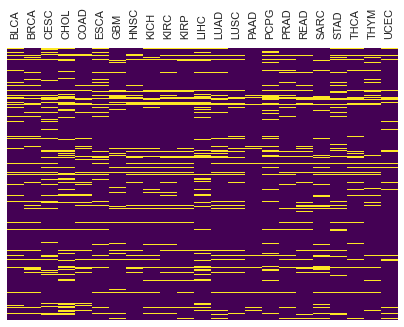

In [33]:
import seaborn
import matplotlib.pyplot as plt

seaborn.set(rc={'figure.figsize': (7,5), 
                'xtick.labeltop': True,
                'xtick.labelbottom': False})

for i in ('consensus_canc', 'consensus_norm'):
    seaborn.heatmap(eval(i).isnull(), 
                    yticklabels=False, 
                    cbar=False, 
                    cmap='viridis')
    plt.savefig(f'../results/misc/{i}_nan_heatmap.png', dpi=300, bbox_inches='tight')

In [11]:
#Compare consensus dataframes element-wise to find differences, stack the resulting dataframe
diff = (consensus_canc != consensus_norm).stack()

#Leave only True = indeed different cases
diff = diff[diff].to_frame()

#Use obtained index to select isoform names from consensus datasets
diff['Cancer'] = diff.index.map(consensus_canc.stack())
diff['Norm'] = diff.index.map(consensus_norm.stack())

diff = (diff.drop(0, axis=1)             #Remove 'True' column
        .dropna())                        #Remove NaN values
        #.groupby(level=0)                #Group by gene to...
        #.filter(lambda x: len(x) > 3))  #...filter by length of samples > 3

diff.to_excel('../results/tcga_prevailing_diff_all.xlsx')

In [64]:
def extract_form_freq(isoform_list: pandas.Series):
    
    isoform_counts = isoform_list.value_counts(normalize=True)
    return isoform_counts

def consider_gene(gene: str, canc: str, norm: str):
    global samples
    
    form_freq = pandas.DataFrame(index=[canc, norm], columns=samples)
    for s in samples:
        try:
            canc = pandas.read_csv(f'../data/tcga_prevailing/{s}_canc.csv', index_col=0)[gene]
        try:
            norm = pandas.read_csv(f'../data/tcga_prevailing/{s}_norm.csv', index_col=0)[gene]
        except
        temp = pandas.concat(canc, norm)
        form_freq[f'{s}'] = temp.apply(pandas.Series.value_counts, axis=1, normalize=True)
        
    return form_freq

In [ ]:
form_freq('NLRP3', '')

In [ ]:
def consider_gene(gene: str):
    global samples
    canc_all = [pandas.read_csv(f'../data/tcga_prevailing/{s}_canc.csv', index_col=0)[gene] for s in samples]
    norm_all = [pandas.read_csv(f'../data/tcga_prevailing/{s}_norm.csv', index_col=0)[gene] for s in samples]
    isoforms_canc, isoforms_norm = set(), set()
    isoforms_canc = [isoforms_canc | set(i.index) for i in canc_all]
    isoforms_norm = [isoforms_norm | set(i.index) for i in norm_all]
    index_level_1 = ['Canc'] * len(isoforms_canc) + ['Norm'] * len(isoforms_norm)
    index_level_2 = 

In [71]:
CESC_canc_prev = pandas.read_csv(f'../data/tcga_prevailing/CESC_canc.csv', index_col=0)

In [75]:
'NLRP3' in genes_all

True

In [76]:
sc_data = pandas.read_csv(f'../data/tcga_initial/KIDNEY_canc.tsv', sep='\t')

In [77]:
sc_data

,UniProt,canonical,chr,Gene,ucsc,Avg,TCGA-3Z-A93Z-01A-11R-A37O-07,TCGA-6D-AA2E-01A-11R-A37O-07,TCGA-A3-3306-01A-01R-0864-07,TCGA-A3-3307-01A-01R-0864-07,...,TCGA-G6-A5PC-01A-11R-A33J-07,TCGA-G6-A8L6-01A-11R-A37O-07,TCGA-G6-A8L7-01A-11R-A37O-07,TCGA-G6-A8L8-01A-21R-A37O-07,TCGA-GK-A6C7-01A-11R-A33J-07,TCGA-MM-A563-01A-11R-A266-07,TCGA-MM-A564-01A-11R-A266-07,TCGA-MM-A84U-01A-11R-A37O-07,TCGA-MW-A4EC-01A-11R-A266-07,TCGA-T7-A92I-01A-11R-A37O-07
0,A0A5B9,A0A5B9,chr07,TRBC2,uc003wbh,5.858151,6.717287,6.139183,4.646791,6.682648,...,8.404824,7.283078,5.954441,6.145415,6.411692,7.267070,6.693225,6.543726,5.648785,5.294955
1,A0AUZ9,A0AUZ9,chr02,KANSL1L,uc002vds,9.869458,10.043090,9.317853,10.667831,10.736789,...,9.358876,9.760936,7.452617,10.163722,10.167995,9.587088,9.512076,10.047196,9.846372,10.163091
2,A0AUZ9-3,A0AUZ9,chr02,KANSL1L,uc002vdv,4.492186,3.256044,3.051998,4.198361,5.516050,...,4.519976,1.693320,4.607833,5.323903,5.906633,3.200740,4.059156,4.267423,4.128434,6.132859
3,A0AUZ9-4,A0AUZ9,chr02,KANSL1L,uc002vdx,3.734040,2.783121,2.936892,4.477502,4.419802,...,2.369327,3.096110,3.695816,5.727360,4.161436,4.235543,3.294827,3.138536,4.170630,5.123248
4,A0AV02,A0AV02,chr03,SLC12A8,uc003ehv,4.266896,3.561595,5.993131,0.000000,0.000000,...,0.000000,3.725021,3.742168,5.956466,0.000000,5.332174,0.000000,4.643366,2.472514,3.337540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16348,Q9Y6X8,Q9Y6X8,chr08,ZHX2,uc003ypk,10.484030,9.711988,9.977429,11.147350,10.707830,...,9.739521,9.935917,10.405080,10.177030,10.385800,10.258240,11.077300,10.988610,9.992171,9.808294
16349,Q9Y6Y1,Q9Y6Y1,chr01,CAMTA1,uc001aoi,3.049786,1.536103,3.193062,0.000000,2.878078,...,1.188464,0.000000,0.000000,0.000000,4.775830,1.960882,0.000000,0.000000,2.785613,4.930430
16350,Q9Y6Y8,Q9Y6Y8,chr10,SEC23IP,uc001leu,9.578392,8.310626,9.390266,9.864598,9.903900,...,5.556074,6.962933,5.172432,7.813603,10.249460,8.722094,6.941274,8.522002,9.363577,10.746870
16351,Q9Y6Y9,Q9Y6Y9,chr08,LY96,uc003yad,7.106960,6.491983,8.726037,6.509422,6.766930,...,6.312184,6.633691,5.621750,5.019791,5.863036,8.075069,6.505645,8.347560,6.848053,9.551450


In [79]:
tissues = ['bladder', 'esophagus', 'kidney', 'liver', 'lung', 'stomach']

In [81]:
start = timeit.default_timer()
for i, s in enumerate(tissues):
    new = timeit.default_timer()
    
    #Handle 'cancer' dataset
    sc_data = pandas.read_csv(f'../data/tcga_initial/{s}_canc.tsv', sep='\t')
    sc_prev = assign_prevailing_forms(sc_data)
    sc_prev.to_csv(f'../data/tcga_prevailing/{s}_canc.csv', index=True)
    
    #Handle 'norm' dataset
    sn_data = pandas.read_csv(f'../data/tcga_initial/{s}_norm.tsv', sep='\t')
    sn_prev = assign_prevailing_forms(sn_data)
    sn_prev.to_csv(f'../data/tcga_prevailing/{s}_norm.csv', index=True)
    
    elapsed_one = timeit.default_timer() - new
    elapsed_total = timeit.default_timer() - start
    
    msg = f'Done {i+1} out of {len(samples)} samples, '\
          f'last took {elapsed_one:.2f} s, total {elapsed_total:.2f} s'
    
    print(msg, end='\r')

In [11]:
samples = ['BLCA', 'BRCA', 'CESC', 'CHOL', 'COAD',
           'ESCA', 'GBM', 'HNSC', 'KICH', 'KIRC',
           'KIRP', 'LIHC', 'LUAD', 'LUSC', 'MESO',
           'PAAD', 'PCPG', 'PRAD', 'READ', 'SARC', 
           'STAD', 'THCA', 'THYM', 'UCEC']

In [23]:
for s in samples:
    canc_all = [pandas.read_csv(f'../data/tcga_initial/{s}_canc.tsv',
                                sep='\t', nrows=2) for s in samples]
    canc_all_len = [len(i.columns) - 6 for i in canc_all]
    
    norm_all = [pandas.read_csv(f'../data/tcga_initial/{s}_norm.tsv',
                                sep='\t', nrows=2) for s in samples]
    norm_all_len = [len(i.columns) - 6 for i in norm_all]
    
    data_len = pandas.DataFrame(data={'Type': samples,
                                      'Cancer': canc_all_len,
                                      'Norm': norm_all_len})
    data_len.to_excel('../results/data_len.xlsx', index=False)

In [19]:
x = pandas.read_csv(f'../data/tcga_initial/BLCA_canc.tsv', sep='\t', nrows=2)

In [22]:
canc_all_len

[405,
 1080,
 296,
 36,
 282,
 173,
 142,
 515,
 66,
 529,
 289,
 369,
 512,
 496,
 82,
 178,
 176,
 483,
 91,
 258,
 413,
 496,
 120,
 175]

In [36]:
tissues = ['BLADDER', 'ESOPHAGUS', 'KIDNEY', 'LIVER', 'LUNG', 'STOMACH']

for t in tissues:

    #Handle 'cancer' dataset
    sc_data = pandas.read_csv(f'../data/tcga_initial/{t}_canc.tsv', sep='\t')
    sc_prev = assign_prevailing_forms(sc_data)
    sc_prev.to_csv(f'../data/tcga_prevailing/{t}_canc.csv', index=True)
    
    #Handle 'norm' dataset
    sn_data = pandas.read_csv(f'../data/tcga_initial/{t}_norm.tsv', sep='\t')
    sn_prev = assign_prevailing_forms(sn_data)
    sn_prev.to_csv(f'../data/tcga_prevailing/{t}_norm.csv', index=True)

In [40]:
#Create a list of all genes from all datasets
genes_all = set()
for s in tissues:
    genes_canc = set(pandas.read_csv(f'../data/tcga_prevailing/{s}_canc.csv', usecols=[0])['Gene'].to_list())
    genes_norm = set(pandas.read_csv(f'../data/tcga_prevailing/{s}_norm.csv', usecols=[0])['Gene'].to_list())
    genes_all = genes_canc | genes_norm
    
genes_all = sorted(list(genes_all))

#Create dataframes to aggregate results
consensus_canc = pandas.DataFrame(index=genes_all, columns=tissues)
consensus_norm = pandas.DataFrame(index=genes_all, columns=tissues)

for s in tissues:
    sdata_prev = pandas.read_csv(f'../data/tcga_prevailing/{s}_canc.csv', index_col=0)
    #Apply function to get dominant isoform or each gene in a dataset
    consensus_canc[f'{s}'] = sdata_prev.apply(extract_dominant_form, axis=1)
    
for s in tissues:
    sdata_prev = pandas.read_csv(f'../data/tcga_prevailing/{s}_norm.csv', index_col=0)
    #Apply function to get dominant isoform or each gene in a dataset
    consensus_norm[f'{s}'] = sdata_prev.apply(extract_dominant_form, axis=1)

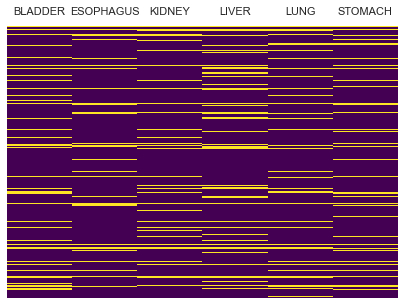

In [42]:
import seaborn
import matplotlib.pyplot as plt

seaborn.set(rc={'figure.figsize': (7,5), 
                'xtick.labeltop': True,
                'xtick.labelbottom': False})

for i in ('consensus_canc', 'consensus_norm'):
    seaborn.heatmap(eval(i).isnull(), 
                    yticklabels=False, 
                    cbar=False, 
                    cmap='viridis')
    plt.savefig(f'../results/misc/{i}_tissue_nan_heatmap.png', dpi=300, bbox_inches='tight')

In [57]:
#Compare consensus dataframes element-wise to find differences, stack the resulting dataframe
diff = (consensus_canc != consensus_norm).stack()

#Leave only True = indeed different cases
diff = diff[diff].to_frame()

#Use obtained index to select isoform names from consensus datasets
diff['Cancer'] = diff.index.map(consensus_canc.stack())
diff['Norm'] = diff.index.map(consensus_norm.stack())

diff = (diff.drop(0, axis=1)             #Remove 'True' column
        .dropna()                        #Remove NaN values
        .groupby(level=0)                #Group by gene to...
        .filter(lambda x: len(x) > 1))  #...filter by length of samples > 3

diff.to_excel('../results/consensus_tissue_diff.xlsx')

In [58]:
diff

Cancer      Norm
ARHGEF4 KIDNEY     Q9NR80-4    Q9NR80
        LIVER      Q9NR80-4    Q9NR80
CPT1C   BLADDER    Q8TCG5-2  Q8TCG5-3
        LUNG       Q8TCG5-2  Q8TCG5-3
EDN3    KIDNEY       P14138  P14138-2
        LUNG         P14138  P14138-2
EXO1    LIVER        Q9UQ84  Q9UQ84-4
        LUNG         Q9UQ84  Q9UQ84-4
FAM135B ESOPHAGUS  Q49AJ0-3    Q49AJ0
        STOMACH    Q49AJ0-3    Q49AJ0
KCNMA1  BLADDER    Q12791-6  Q12791-5
        KIDNEY     Q12791-6  Q12791-5
KIRREL2 KIDNEY     Q6UWL6-3    Q6UWL6
        STOMACH    Q6UWL6-3    Q6UWL6
NLRP3   ESOPHAGUS  Q96P20-3  Q96P20-2
        STOMACH    Q96P20-3  Q96P20-2
PANX2   ESOPHAGUS  Q96RD6-2    Q96RD6
        KIDNEY       Q96RD6  Q96RD6-2
PDZD3   KIDNEY       Q86UT5  Q86UT5-2
        LIVER        Q86UT5  Q86UT5-3
RDM1    ESOPHAGUS    Q8NG50  Q8NG50-4
        STOMACH      Q8NG50  Q8NG50-4
SCEL    BLADDER      O95171  O95171-2
        STOMACH      O95171  O95171-2
SLC26A5 BLADDER    P58743-4    P58743
        LUNG       P58743-4  P58743-2
VWA5B1  ESOPHAGUS  Q5TIE3-3  Q5TIE3-5
        KIDNEY     Q5TIE3-3  Q5TIE3-2

In [49]:
diff = diff[diff].to_frame()

In [54]:
diff['Norm'] = diff.index.map(consensus_norm.stack())

In [52]:
diff['Cancer'] = diff.index.map(consensus_canc.stack())

In [56]:
diff.dropna()

,,0,Cancer,Norm
ADAM12,ESOPHAGUS,True,O43184,O43184-3
ADGRE3,ESOPHAGUS,True,Q9BY15,Q9BY15-2
ALS2CR11,ESOPHAGUS,True,Q53TS8,Q53TS8-2
AQP4,ESOPHAGUS,True,P55087-2,P55087
ARHGAP19,ESOPHAGUS,True,Q14CB8-6,Q14CB8-3
...,...,...,...,...
VWA5B1,KIDNEY,True,Q5TIE3-3,Q5TIE3-2
WAC,ESOPHAGUS,True,Q9BTA9-5,Q9BTA9-2
WDSUB1,KIDNEY,True,Q8N9V3-2,Q8N9V3
ZMYND8,KIDNEY,True,Q9ULU4-8,Q9ULU4-6
